In [355]:
# Python packages and utilities
import os
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# try:
import mlxtend
# except ModuleNotFoundError:
#     !pip install mlxtend

#RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs

# Mordred
try:
    import mordred
    from mordred import Calculator, descriptors
except ModuleNotFoundError:
    !pip install 'mordred[full]'
    import mordred
    from mordred import Calculator, descriptors
    

# scikit-learn
try:
    import sklearn
except ModuleNotFoundError:
    !pip install -U scikit-learn
    import sklearn
    
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.feature_selection import RFECV, RFE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFECV, RFE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
kernel = DotProduct() + WhiteKernel()

try:
    import smogn
except ModuleNotFoundError:
    !pip install smogn
    import smogn

#imbalenced learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
except ModuleNotFoundError:
    !pip install -U imbalanced-learn
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN

try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt

# scikitplot library
try:
    import scikitplot as skplt
except ModuleNotFoundError:
    !pip install scikit-plot
    import scikitplot as skplt

!pip install pip install -U imbalanced-learn

# own module
from Modules import classification_metrics as cmetrics
try:
    from Modules import finger_prints as fp
except ModuleNotFoundError:
    !python -m pip install "dask[complete]"
from Modules import molecules_and_images as mo
from Modules import plotting_sklearn as pltsk
from Modules import classification_workflow_functions as cwf

# utility
%load_ext autoreload
%autoreload 2
%aimport
import importlib


import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)


random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


Random seed fixed as 10459


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [356]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

In [357]:
data = pd.read_csv("Second_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [358]:
log.info("Columns: {}".format(data.columns))

Columns: Index(['reaction', 'substrate', 'catalyst', 'solvent', 'solvent_code',
       'temperature', 'ee', 'ddg', 'paper'],
      dtype='object')


In [359]:
substratesmiles = data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles.head()))

catalystsmiles = data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles.head()))

reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

ddg = data["ddg"]
log.info("DGG: {}".format(ddg.head()))


Substrate SMILES: 0        O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2
1    O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2
2              O=C1CCC(Cl)N1CCC2=CSC=C2
3      O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3
4              O=C1CCC(Cl)N1CCC2=CNC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
1    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
2    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
3    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
4    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
Name: catalyst, dtype: object
Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64
DGG: 0    0.000000
1    0.000000
2    1.426491
3    0.696565
4    3.194526
Name: ddg, dtype: float64


In [360]:
targets = ddg

In [361]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list = [cwf.get_mol_from_smiles(s) for s in substratesmiles]
subfeatures_df = calc.pandas(submolecule_list)

100%|██████████| 90/90 [00:18<00:00,  4.94it/s]


In [362]:
subbackup_feature_df = subfeatures_df.copy()

In [363]:
subfeatures_df.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df.index)))
threshold = 0.5
subfeatures_df.drop(subfeatures_df.std()[subfeatures_df.std() < threshold].index.values, axis=1)
subfeatures_df.columns = [ent.strip() for ent in subfeatures_df.columns]
subfeatures_df.head()

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,ABC,ABCGG,nAcid,nBase,SpAbs_A,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,12.865821,11.266795,0,0,21.826366,...,22,84.0,96.0,5.805556,3.888889
1,14.239595,12.684052,0,0,24.263559,...,27,94.0,109.0,6.916667,4.416667
2,10.744501,10.260282,0,0,17.982356,...,15,70.0,80.0,4.444444,3.138889
3,14.199155,12.457708,0,0,23.804025,...,25,96.0,114.0,5.166667,3.944444
4,10.744501,10.260282,0,0,17.982356,...,15,70.0,80.0,4.444444,3.138889


In [364]:
log.info(subfeatures_df)
subfeature_types = "some_catagorical"# other options 'some_catagorical', 'no_catagorical'

          ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  \
0   12.865821  11.266795      0      0  21.826366  ...    22     84.0   
1   14.239595  12.684052      0      0  24.263559  ...    27     94.0   
2   10.744501  10.260282      0      0  17.982356  ...    15     70.0   
3   14.199155  12.457708      0      0  23.804025  ...    25     96.0   
4   10.744501  10.260282      0      0  17.982356  ...    15     70.0   
..        ...        ...    ...    ...        ...  ...   ...      ...   
85  16.507753  14.449726      0      0  26.915709  ...    32    114.0   
86  14.906262  12.447004      0      0  24.908084  ...    28    100.0   
87  15.800646  13.284771      0      0  25.538663  ...    31    108.0   
88  17.763048  14.857121      0      0  29.788121  ...    36    120.0   
89  15.093540  13.289946      0      0  24.480946  ...    28    104.0   

    Zagreb2  mZagreb1  mZagreb2  
0      96.0  5.805556  3.888889  
1     109.0  6.916667  4.416667  
2      80.0  4.444444

In [365]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list = [cwf.get_mol_from_smiles(s) for s in catalystsmiles]
catfeatures_df = calc.pandas(catmolecule_list)

100%|██████████| 90/90 [00:34<00:00,  2.63it/s]


In [366]:
catbackup_feature_df = catfeatures_df.copy()

In [367]:
catfeatures_df.dropna(inplace=True, thresh=int(0.9*len(catfeatures_df.index)))
threshold = 0.5
catfeatures_df.drop(catfeatures_df.std()[catfeatures_df.std() < threshold].index.values, axis=1)
catfeatures_df.columns = [ent.strip() for ent in catfeatures_df.columns]
catfeatures_df.head()

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,ABC,ABCGG,nAcid,nBase,SpAbs_A,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,27.439682,23.068997,0,0,44.916702,...,56,182.0,211.0,13.423611,8.027778
1,27.439682,23.068997,0,0,44.916702,...,56,182.0,211.0,13.423611,8.027778
2,27.439682,23.068997,0,0,44.916702,...,56,182.0,211.0,13.423611,8.027778
3,27.439682,23.068997,0,0,44.916702,...,56,182.0,211.0,13.423611,8.027778
4,27.439682,23.068997,0,0,44.916702,...,56,182.0,211.0,13.423611,8.027778


In [368]:
log.info(catfeatures_df)
catfeature_types = "some_catagorical" 

          ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  \
0   27.439682  23.068997      0      0  44.916702  ...    56    182.0   
1   27.439682  23.068997      0      0  44.916702  ...    56    182.0   
2   27.439682  23.068997      0      0  44.916702  ...    56    182.0   
3   27.439682  23.068997      0      0  44.916702  ...    56    182.0   
4   27.439682  23.068997      0      0  44.916702  ...    56    182.0   
..        ...        ...    ...    ...        ...  ...   ...      ...   
85  27.439682  23.068997      0      0  44.916702  ...    56    182.0   
86  27.439682  23.068997      0      0  44.916702  ...    56    182.0   
87  27.439682  23.068997      0      0  44.916702  ...    56    182.0   
88  27.439682  23.068997      0      0  44.916702  ...    56    182.0   
89  27.439682  23.068997      0      0  44.916702  ...    56    182.0   

    Zagreb2   mZagreb1  mZagreb2  
0     211.0  13.423611  8.027778  
1     211.0  13.423611  8.027778  
2     211.0  13.42

In [369]:
subreasonable_predicted_properties, subsignificant_fearures = cwf.find_correlating_features(subfeatures_df, targets, thresh=0.38, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0     0.000000
1     0.000000
2     1.426491
3     0.696565
4     3.194526
        ...   
85    4.957045
86    4.088429
87    5.156630
88    6.314769
89    4.464572
Name: ddg, Length: 90, dtype: float64
Significance will be calculated for the correlations
SpMax_A: 0.3876 P: 0.0004 Significant at 0.0500 level? True
ATS0s: 0.4182 P: 0.0004 Significant at 0.0500 level? True
ATS2s: 0.3840 P: 0.0004 Significant at 0.0500 level? True
ATSC8se: -0.4105 P: 0.0002 Significant at 0.0500 level? True
AATSC1pe: -0.3965 P: 0.0002 Significant at 0.0500 level? True
AATSC1are: -0.3853 P: 0.0004 Significant at 0.0500 level? True
VR2_Dzse: 0.3804 P: 0.0004 Significant at 0.0500 level? True
VR2_Dzpe: 0.3802 P: 0.0004 Significant at 0.0500 level? True
VR2_Dzare: 0.3803 P: 0.0004 Significant at 0.0500 level? True
AXp-3d: -0.4070 P: 0.0002 Significant at 0.0500 level? True
AXp-5d: -0.4042 P: 0.0002 Significant at 0.0500 level? True
AXp-6d: -0.4009 P: 0.0002 Significant at 0.0500 level? True
AXp-7d: -0.4183 P:

In [370]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_fearures, len(subsignificant_fearures)))
use_significant = True
use_reasonable = False

['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are', 'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d', 'AXp-5d', 'AXp-6d', 'AXp-7d', 'TIC1', 'FilterItLogS', 'MID_N', 'MPC2', 'MPC4', 'MPC6', 'TMPC10', 'GGI6', 'MWC02', 'MWC03', 'MWC04', 'MWC05', 'MWC06', 'MWC07', 'MWC08', 'MWC09', 'MWC10', 'SRW04', 'SRW06', 'SRW08', 'SRW10', 'TSRW10'] 35
['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are', 'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d', 'AXp-5d', 'AXp-6d', 'AXp-7d', 'TIC1', 'FilterItLogS', 'MID_N', 'MPC2', 'MPC4', 'MPC6', 'TMPC10', 'GGI6', 'MWC02', 'MWC03', 'MWC04', 'MWC05', 'MWC06', 'MWC07', 'MWC08', 'MWC09', 'MWC10', 'SRW04', 'SRW06', 'SRW08', 'SRW10', 'TSRW10'] 35


In [372]:
catreasonable_predicted_properties, catsignificant_fearures = cwf.find_correlating_features(catfeatures_df, targets, thresh=0.49, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0     0.000000
1     0.000000
2     1.426491
3     0.696565
4     3.194526
        ...   
85    4.957045
86    4.088429
87    5.156630
88    6.314769
89    4.464572
Name: ddg, Length: 90, dtype: float64
Significance will be calculated for the correlations
AATS7s: -0.4934 P: 0.0002 Significant at 0.0500 level? True
AATS7se: -0.4962 P: 0.0002 Significant at 0.0500 level? True
AATS7pe: -0.5249 P: 0.0002 Significant at 0.0500 level? True
AATS7are: -0.5153 P: 0.0002 Significant at 0.0500 level? True
AATSC0d: -0.5154 P: 0.0002 Significant at 0.0500 level? True
AATSC2d: 0.4946 P: 0.0002 Significant at 0.0500 level? True
AATSC3v: 0.4905 P: 0.0002 Significant at 0.0500 level? True
AATSC3p: 0.4906 P: 0.0002 Significant at 0.0500 level? True
MATS8c: 0.4964 P: 0.0002 Significant at 0.0500 level? True
MATS1s: 0.4917 P: 0.0002 Significant at 0.0500 level? True
GATS2c: 0.5127 P: 0.0002 Significant at 0.0500 level? True
GATS4dv: 0.5051 P: 0.0002 Significant at 0.0500 level? True
GATS4d: 0.5401 P: 0.00

In [373]:
log.info("{} {}".format(catreasonable_predicted_properties, len(catreasonable_predicted_properties)))
log.info("{} {}".format(catsignificant_fearures, len(catsignificant_fearures)))
use_significant = True
use_reasonable = False

['AATS7s', 'AATS7se', 'AATS7pe', 'AATS7are', 'AATSC0d', 'AATSC2d', 'AATSC3v', 'AATSC3p', 'MATS8c', 'MATS1s', 'GATS2c', 'GATS4dv', 'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'NssssC', 'ETA_shape_x', 'ZMIC3', 'ZMIC4', 'SlogP_VSA3', 'JGI5'] 22
['AATS7s', 'AATS7se', 'AATS7pe', 'AATS7are', 'AATSC0d', 'AATSC2d', 'AATSC3v', 'AATSC3p', 'MATS8c', 'MATS1s', 'GATS2c', 'GATS4dv', 'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'NssssC', 'ETA_shape_x', 'ZMIC3', 'ZMIC4', 'SlogP_VSA3', 'JGI5'] 22


In [374]:
subfeats_df = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_fearures:
        subfeats_df[k] = subfeatures_df[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df[k] = subfeatures_df[k]

In [375]:
catfeats_df = pd.DataFrame()

if use_significant is True:
    for k in catsignificant_fearures:
        catfeats_df[k] = catfeatures_df[k]
        
elif use_reasonable is True:
    for k in catreasonable_predicted_properties:
        catfeats_df[k] = catfeatures_df[k]

In [380]:
features_df = subfeats_df.join(catfeats_df, lsuffix="subfeats_df", rsuffix="catfeats_df")

In [381]:
features_df.to_csv("features.csv")

In [382]:
feature_types = "some_catagorical"
# NOTE: USER DEFINES THE LIST BELOW!!!!!! here is with 0.4 for subs and 0.6 for cats no categorical-spearman
# for 0.36 sub and o.55 cats -spearman
# catagorical_indxs = [23, 25, 48, 49, 50]
# for pearson with 0.36 sub and o.55 cats 
catagorical_indxs = [16,17,18,19,51]
feature_columns = features_df.columns

# Backup
backup_feats_df = features_df.copy()

# None catagorical only scale the data as numbers
if feature_types == "no_catagorical":
    mm_scaler = MinMaxScaler()
    features_df = mm_scaler.fit_transform(features_df)
    log.info(pd.DataFrame(features_df, columns=feature_columns))
    features_df = pd.DataFrame(features_df, columns=feature_columns)
    
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    numeric_features = [feature_columns[i] for i in range(len(feature_columns)) if i not in catagorical_indxs]
    numerical_transformer = MinMaxScaler()
    categorical_features = [feature_columns[i] for i in range(len(feature_columns)) if i in catagorical_indxs]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    if any(ent in categorical_features for ent in numeric_features):
        log.warning("WARNING - numeric and catagorical feature specififed overlap")
        log.info(numeric_features)
        log.info(categorical_features)
    else:
        log.info("Numerical features:\n{} {}".format(numeric_features, len(numeric_features)))
        log.info("Catagorical features:\n{} {}".format(categorical_features, len(catagorical_indxs)))
    
    preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numeric_features),
        ('catagorical', categorical_transformer, categorical_features)])
    
    features_df = preprocessor.fit_transform(features_df)
    feature_names = cwf.get_feature_names_from_column_transformers(preprocessor)
    catagorical_indxs = [i for i in range(len(numeric_features), len(feature_names))]
    log.info(feature_names)

    log.info(pd.DataFrame(features_df, columns=feature_names))
    features_df = pd.DataFrame(features_df, columns=feature_names)
    log.info("catagorical indexes {}".format(catagorical_indxs))
    log.info("Catagorical features start on column name {} and end on {}".format(features_df.columns[catagorical_indxs[0]], features_df.columns[catagorical_indxs[-1]]))
    
# All catagorical
elif feature_types == "catagorical":
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    features_df = categorical_transformer.fit_transform(features_df).toarray()
    feature_names = [categorical_transformer.get_feature_names(feature_columns)]
    features_df = pd.DataFrame(features_df, columns=feature_names)
    log.info(features_df)

# No scaling or other encoding
else:
    log.info("No scaling")

Numerical features:
['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are', 'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d', 'AXp-5d', 'AXp-6d', 'AXp-7d', 'TIC1', 'FilterItLogS', 'MID_N', 'GGI6', 'MWC02', 'MWC03', 'MWC04', 'MWC05', 'MWC06', 'MWC07', 'MWC08', 'MWC09', 'MWC10', 'SRW04', 'SRW06', 'SRW08', 'SRW10', 'TSRW10', 'AATS7s', 'AATS7se', 'AATS7pe', 'AATS7are', 'AATSC0d', 'AATSC2d', 'AATSC3v', 'AATSC3p', 'MATS8c', 'MATS1s', 'GATS2c', 'GATS4dv', 'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'ETA_shape_x', 'ZMIC3', 'ZMIC4', 'SlogP_VSA3', 'JGI5'] 52
Catagorical features:
['MPC2', 'MPC4', 'MPC6', 'TMPC10', 'NssssC'] 5

-----
Getting feature names from column transformer
-----

Transformer index: 0
Tranformer name: numerical
Transformer: MinMaxScaler()
Original feature names: ['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are', 'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d', 'AXp-5d', 'AXp-6d', 'AXp-7d', 'TIC1', 'FilterItLogS', 'MID_N', 'GGI6', 'MWC02', 'MWC03', 'MWC04', 'MWC0

In [383]:
def grid_search_classifier_parameters(rgs, Xtrain, ytrain, rgs_options, rgs_names, iteration, no_train_output, cv=5, name=None,scoring=("r2","neg_root_mean_squared_error")):
    """
    Grid search calssifer hyperparams and find the best report metrics if requested
    """
    log = logging.getLogger(__name__)
    
    # Grid search model optimizer
    parameters = rgs_options[rgs_names[iteration]]
    log.debug("\tname: {} parameters: {}".format(name, parameters))
    
    optparam_search = GridSearchCV(rgs, parameters, cv=cv, error_score=np.nan, scoring=scoring, refit=scoring[0], return_train_score=True)
    log.debug("\tCV xtrain: {}".format(Xtrain))
    
    optparam_search.fit(Xtrain, ytrain.values.ravel())
    opt_parameters = optparam_search.best_params_
    
    if no_train_output is False:
        reported_metrics = pd.DataFrame(data=optparam_search.cv_results_)
        reported_metrics.to_csv("{}/{}_grid_search_metrics.csv".format(name,name))
        log.info("\tBest parameters; {}".format(opt_parameters))

        for mean, std, params in zip(optparam_search.cv_results_["mean_test_{}".format(scoring[0])], optparam_search.cv_results_["std_test_{}".format(scoring[0])], optparam_search.cv_results_['params']):
            log.info("\t{:.4f} (+/-{:.4f}) for {}".format(mean, std, params))
    else:
        pass
    
    return opt_parameters



In [384]:
def minmaxscale(df):
    """
    scale a pandas dataframe using min max scaling
    :param df: pandas dataframe - data frame to be returned scaled
    """
    
    df_tmp = df.copy()
    normalized_df = (df_tmp-df_tmp.min())/(df_tmp.max()-df_tmp.min())
    return normalized_df

In [385]:
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
def kfold_test_imbalenced_classifiers_with_optimization(df, targets, regressors, rgs_options, scale=True, cv=5, n_repeats=20, rgs_names=None, 
                                                         no_train_output=False, test_set_size=0.2, smiles=None, names=None,
                                                        random_seed=107901, overwrite=True):
    """
    function to run classification test over classifiers using imbalenced resampling
    inspired from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
    :param df: dataframe - data frame of features and identifers (smiles and/or names)
    :param classes: iterable - list of classes/labels
    :param classifiers: list - list of classifier methods
    :param plot: true/false - plot the results or not
    """
    
    log = logging.getLogger(__name__)
    
    log.info("Features: {}".format(df.columns))
    
    log_df = pd.DataFrame()
    labelpredictions = pd.DataFrame()
    
    list_report, list_roc_auc, list_opt_param, list_score, list_c_matrix=[],[],[],[],[]
    list_average_roc_auc,list_average_scores=[],[]
    disp,predictions,actual,index,same = [], [], [],[],[]
    probablity=[]
    
    iteration = 0
    pd.set_option('display.max_columns', 20)
        
    if rgs_names is None:
        rgs_names = [i for i in range(0, len(regressors))]
    
    # Kfold n_repeats is the number of folds to run.
    # Setting the random seed determines the degree of randomness. This means run n_repeats of 
    # independent cross validators.

    kf = KFold(n_splits=n_repeats, shuffle=True, random_state=random_seed)
    log.info("Starting regression")
    for name, classf in zip(rgs_names, regressors):
        log.info("\n-----\nBegin {}\n-----\n".format(name))
        
        kf_iteration = 0
        scores = []
        score_list = []
        tmp = []
        name = "{}".format("_".join(name.split()))
        
        # Make directory for each classifier
        if not os.path.isdir(name):
            os.makedirs(name, exist_ok = True)
        elif overwrite is False and os.path.isdir(name) is True:
            log.warning("Directory already exists and overwrite is False will stop before overwriting.".format(name))
            return None
        else:
            log.info("Directory {} already exists will be overwritten".format(name))
        
        # Loop over  Kfold here 
        for train_indx, test_indx in kf.split(df):
            log.info("----- {}: Fold {} -----".format(name, kf_iteration))
            
            tmp = tmp + test_indx.tolist()
            log.info(test_indx.tolist())
            
            # Set the training and testing sets by train test index
            log.info("\tTrain indx {}\n\tTest indx: {}".format(train_indx, test_indx))
            
            # Train
            Xtrain = df.iloc[train_indx]
            log.debug("Train X\n{}".format(Xtrain))
            ytrain = targets.iloc[train_indx]
            log.debug("Train Y\n{}".format(ytrain))
            
            # Test
            Xtest = df.iloc[test_indx]
            log.debug("Test X\n{}".format(Xtest))
            ytest = targets.iloc[test_indx]
            log.debug("Test Y\n{}".format(ytest))
            
            # way to calculate the test indexes
            #test_i = np.array(list(set(df.index) - set(train_indx)))

            # Grid search model optimizer
            opt_param = grid_search_classifier_parameters(classf, Xtrain, ytrain, rgs_options, rgs_names, iteration, no_train_output, cv=cv, name=name)
            
            list_opt_param.append(opt_param)
            
            # Fit final model using optimized parameters
            clf = classf
            clf.set_params(**opt_param)
            log.info("\n\t----- Predicting using: {} -----".format(name))
            log.debug("\tXtrain: {}\n\tXtest: {}\n\tytrain: {}\n\tytest: {}".format(Xtrain, Xtest, ytrain, ytest))
            clf.fit(Xtrain, ytrain.values.ravel())
#             sc_df.to_csv(os.path.join(name, "fold_{}_score.csv".format(kf_iteration)))
            
            # Evaluate the model
            ## evaluate the model on multiple metric score as list for averaging
            predicted_clf = clf.predict(Xtest)
            sc = mean_absolute_error(ytest, predicted_clf)
            score_list.append(sc)
            
            ## evaluate the principle score metric only (incase different to those above although this is unlikely)
            clf_score = clf.score(Xtest, ytest)
            scores.append(clf_score)
            log.info("\n\tscore ({}): {}".format(name, clf_score))   
            
            pred = [list(test_indx),list(ytest),list(predicted_clf)]
            
            pred = pd.DataFrame(pred)
            pred.T.to_csv("{}/{}.csv".format(name, kf_iteration))
            kf_iteration = kf_iteration + 1
        
        del predictions[:]
        average_scores = np.mean(score_list, axis=0)
        std_scores = np.std(score_list, axis=0)
        log.info("The average scores are: {}, and the std scores are: {}".format(average_scores, std_scores))
        iteration = iteration + 1

#             list_score.append(clf_score)
            

In [386]:
# Possible source:    https://www.kaggle.com/ankitjha/comparing-regression-models

kfold_reg_names = ["LassoCV","KNeighborsRegressor", "DecisionTreeRegressor", "SVR", "BayesianRegr", "GaussianProcess Regressor"]
kfold_regressors = [
    LassoCV(random_state=random_seed, cv=10,selection='random',normalize=True,max_iter=1000000),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=random_seed),
    svm.SVR(),
    linear_model.BayesianRidge(n_iter=100000,normalize=True),
    GaussianProcessRegressor()]

kernel = DotProduct() + WhiteKernel()
kfold_regressors_parameters = {
    "LassoCV":{},
    "KNeighborsRegressor": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "DecisionTreeRegressor": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "SVR": {"kernel":['linear', 'poly', 'rbf'], "degree":[2,3], "gamma":['auto','scale'], "coef0":[0,1], 'C':[100]},    
    "BayesianRegr":{'alpha_1':[1e-06, 10], 'alpha_2': [1e-06,10],'lambda_1':[1e-06,10], 'lambda_2': [1e-06,10]},
    "GaussianProcess Regressor": {},  
  
}

In [387]:
kfold_test_imbalenced_classifiers_with_optimization(features_df,targets , kfold_regressors, kfold_regressors_parameters, scale=True, cv=5, n_repeats=10, rgs_names=kfold_reg_names)

Features: Index(['SpMax_A', 'ATS0s', 'ATS2s', 'ATSC8se', 'AATSC1pe', 'AATSC1are',
       'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'AXp-3d',
       ...
       'TMPC10_670', 'TMPC10_674', 'TMPC10_697', 'TMPC10_782', 'TMPC10_841',
       'NssssC_0', 'NssssC_1', 'NssssC_2', 'NssssC_3', 'NssssC_4'],
      dtype='object', length=154)
Starting regression

-----
Begin LassoCV
-----

----- LassoCV: Fold 0 -----
[1, 3, 18, 21, 56, 59, 64, 78, 86]
	Train indx [ 0  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 57 58 60 61 62 63 65 66 67 68 69 70 71 72 73 74 75 76 77 79
 80 81 82 83 84 85 87 88 89]
	Test indx: [ 1  3 18 21 56 59 64 78 86]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a pre

----- LassoCV: Fold 3 -----
[12, 22, 23, 44, 46, 51, 69, 73, 89]
	Train indx [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 47 48 49 50 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 70 71 72 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88]
	Test indx: [12 22 23 44 46 51 69 73 89]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a pre

----- LassoCV: Fold 6 -----
[19, 27, 31, 35, 53, 70, 71, 76, 84]
	Train indx [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 28 29 30 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 72 73 74 75 77 78 79
 80 81 82 83 85 86 87 88 89]
	Test indx: [19 27 31 35 53 70 71 76 84]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a pre

----- LassoCV: Fold 9 -----
[17, 32, 38, 54, 58, 62, 74, 75, 83]
	Train indx [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 33 34 35 36 37 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 55 56 57 59 60 61 63 64 65 66 67 68 69 70 71 72 73 76 77 78 79
 80 81 82 84 85 86 87 88 89]
	Test indx: [17 32 38 54 58 62 74 75 83]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model

	-0.2587 (+/-0.6072) for {'n_neighbors': 9}

	----- Predicting using: KNeighborsRegressor -----

	score (KNeighborsRegressor): -0.5855774556804361
----- KNeighborsRegressor: Fold 3 -----
[12, 22, 23, 44, 46, 51, 69, 73, 89]
	Train indx [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 47 48 49 50 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 70 71 72 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88]
	Test indx: [12 22 23 44 46 51 69 73 89]
	Best parameters; {'n_neighbors': 9}
	-0.8032 (+/-0.9212) for {'n_neighbors': 2}
	-0.9464 (+/-1.0792) for {'n_neighbors': 3}
	-0.9307 (+/-1.0164) for {'n_neighbors': 4}
	-0.7869 (+/-1.0140) for {'n_neighbors': 5}
	-0.6863 (+/-0.9251) for {'n_neighbors': 6}
	-0.7670 (+/-1.1638) for {'n_neighbors': 7}
	-0.7159 (+/-1.1744) for {'n_neighbors': 8}
	-0.6444 (+/-1.0985) for {'n_neighbors': 9}

	----- Predicting using: KNeighborsRegressor -----

	score (KNeighborsRegressor): -0.

	Best parameters; {'max_depth': 7}
	-0.6433 (+/-0.5466) for {'max_depth': 2}
	-0.5263 (+/-0.4652) for {'max_depth': 3}
	-0.4948 (+/-0.6206) for {'max_depth': 4}
	-0.4072 (+/-0.4755) for {'max_depth': 5}
	-0.2061 (+/-0.4453) for {'max_depth': 7}
	-0.3246 (+/-0.4736) for {'max_depth': 10}

	----- Predicting using: DecisionTreeRegressor -----

	score (DecisionTreeRegressor): -0.2167660603053292
----- DecisionTreeRegressor: Fold 3 -----
[12, 22, 23, 44, 46, 51, 69, 73, 89]
	Train indx [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 47 48 49 50 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 70 71 72 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88]
	Test indx: [12 22 23 44 46 51 69 73 89]
	Best parameters; {'max_depth': 5}
	-0.9130 (+/-1.3088) for {'max_depth': 2}
	-0.6285 (+/-0.9047) for {'max_depth': 3}
	-0.6951 (+/-1.1645) for {'max_depth': 4}
	-0.2170 (+/-0.5629) for {'max_depth': 5}
	-0.4016 (+/-0.8049) f

	-0.1005 (+/-0.6594) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
	-0.1072 (+/-0.6812) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
	-0.6390 (+/-0.9443) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
	-0.2286 (+/-0.5630) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
	-0.0945 (+/-0.3347) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

	----- Predicting using: SVR -----

	score (SVR): 0.16278837038884497
----- SVR: Fold 1 -----
[9, 10, 29, 30, 47, 52, 55, 77, 87]
	Train indx [ 0  1  2  3  4  5  6  7  8 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 49 50 51 53
 54 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79
 80 81 82 83 84 85 86 88 89]
	Test indx: [ 9 10 29 30 47 52 55 77 87]
	Best parameters; {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'pol

	-0.7113 (+/-0.6381) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
	-0.3849 (+/-0.4639) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
	-1.6060 (+/-1.9291) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
	-0.3177 (+/-0.6513) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
	-0.2571 (+/-0.6547) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
	-1.6060 (+/-1.9291) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
	-0.8061 (+/-1.0530) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
	-0.3849 (+/-0.4639) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

	----- Predicting using: SVR -----

	score (SVR): 0.027632379249203587
----- SVR: Fold 4 -----
[2, 8, 26, 28, 37, 40, 57, 60, 61]
	Train indx [ 0  1  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 27 29 30 

	-0.0694 (+/-0.4577) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
	-0.0635 (+/-0.4736) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
	-0.9437 (+/-0.9909) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
	-0.2295 (+/-0.3787) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
	-0.0547 (+/-0.2972) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
	-0.9437 (+/-0.9909) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
	-0.0744 (+/-0.4470) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
	-0.0635 (+/-0.4736) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
	-0.9437 (+/-0.9909) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
	-0.2642 (+/-0.4585) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
	-0.0547 (+/-0.2972) for {'C': 1

	-0.4463 (+/-0.4456) for {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
	-0.2901 (+/-0.3523) for {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
	-1.5822 (+/-1.3816) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
	-0.0742 (+/-0.5104) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
	-0.0699 (+/-0.5062) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
	-1.5822 (+/-1.3816) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
	-0.5406 (+/-0.5323) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
	-0.2901 (+/-0.3523) for {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
	-1.5822 (+/-1.3816) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
	-0.0732 (+/-0.4963) for {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
	-0.0699 (+/-0.5062) for {'C': 1

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

----- BayesianRegr: Fold 4 -----
[2, 8, 26, 28, 37, 40, 57, 60, 61]
	Train indx [ 0  1  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 27 29 30 31 32 33 34 35 36 38 39 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 58 59 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80
 81 82 83 84 85 86 87 88 89]
	Test indx: [ 2  8 26 28 37 40 57 60 61]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.s

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

	Best parameters; {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.1723 (+/-0.5263) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.2381 (+/-0.5832) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-0.3898 (+/-0.5309) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.1749 (+/-0.5348) for {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 10}
	-0.1577 (+/-0.5048) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.2208 (+/-0.5747) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-0.3898 (+/-0.5309) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.1590 (+/-0.5203) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-0.2069 (+/-0.5576) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.2715 (+/-0.5965) for {'alpha_1': 10, 'alpha_2

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

	-0.4104 (+/-1.0839) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-0.5662 (+/-1.3418) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.7119 (+/-1.6052) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-0.2508 (+/-0.2694) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.5391 (+/-1.2980) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 10}
	-0.5174 (+/-1.2640) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-0.6796 (+/-1.5521) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-0.2508 (+/-0.2694) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-0.4955 (+/-1.2282) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}

	----- Predicting using: BayesianRegr -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'no

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

	Best parameters; {}
	-5.5929 (+/-7.4434) for {}

	----- Predicting using: GaussianProcess_Regressor -----

	score (GaussianProcess_Regressor): -3.3986042752384424
----- GaussianProcess_Regressor: Fold 2 -----
[6, 7, 36, 49, 50, 65, 66, 72, 80]
	Train indx [ 0  1  2  3  4  5  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47 48 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 67 68 69 70 71 73 74 75 76 77 78 79
 81 82 83 84 85 86 87 88 89]
	Test indx: [ 6  7 36 49 50 65 66 72 80]
	Best parameters; {}
	-4.0999 (+/-4.2132) for {}

	----- Predicting using: GaussianProcess_Regressor -----

	score (GaussianProcess_Regressor): -13.89804925663565
----- GaussianProcess_Regressor: Fold 3 -----
[12, 22, 23, 44, 46, 51, 69, 73, 89]
	Train indx [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 47 48 49 50 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 70 7

In [388]:
directory_names = cwf.directory_names_from_classfier_names(kfold_reg_names)

In [389]:
directory_names

['LassoCV',
 'KNeighborsRegressor',
 'DecisionTreeRegressor',
 'SVR',
 'BayesianRegr',
 'GaussianProcess_Regressor']

In [390]:
directory_names[0]

'LassoCV'

In [391]:
data = cwf.build_data_from_directory_regr(directory_names[0], max_folds=10)

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv


In [392]:
data

,known,prediction
index,,
0,0.000000,-0.825741
1,0.000000,1.811374
2,1.426491,0.985882
3,0.696565,3.973523
4,3.194526,4.182451
...,...,...
85,4.957045,6.469817
86,4.088429,5.290305
87,5.156630,5.439458



-----
Analyzing predictions for model LassoCV
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.4864698932978706, MAE: 1.2618908925052807, MSE: 2.5860808572973406,R2: 0.482450343255167
-----


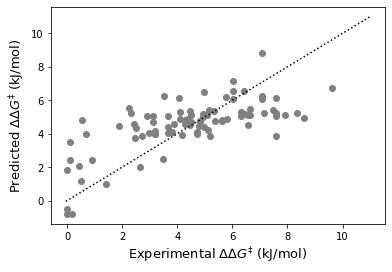


-----
Analyzing predictions for model KNeighborsRegressor
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.37312928629865694, MAE: 1.4351615862464506, MSE: 3.43727536235272,R2: 0.3121016773689449
-----


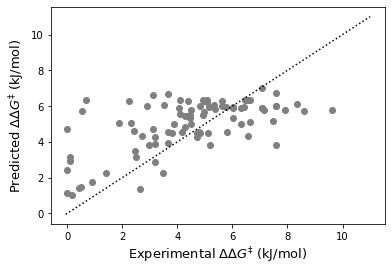


-----
Analyzing predictions for model DecisionTreeRegressor
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.25017463986410604, MAE: 1.525050161649003, MSE: 3.7524258921518365,R2: 0.24903093151030842
-----


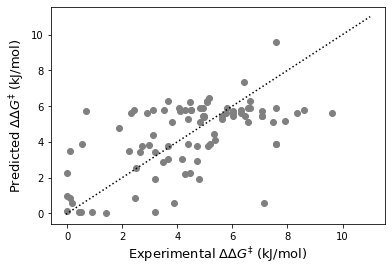


-----
Analyzing predictions for model SVR
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.43846193498921837, MAE: 1.2936810282167102, MSE: 2.8112947438193605,R2: 0.43737852373539576
-----


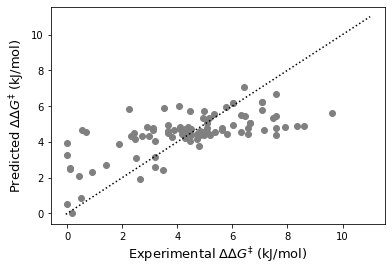


-----
Analyzing predictions for model BayesianRegr
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.45173171089262887, MAE: 1.2946586095319934, MSE: 2.742456978213459,R2: 0.451154953756864
-----


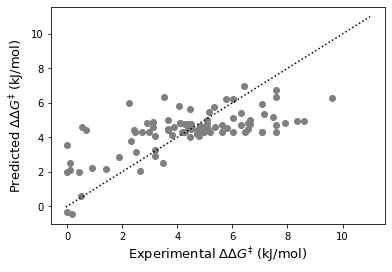


-----
Analyzing predictions for model GaussianProcess_Regressor
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: -1.3550257502225316, MAE: 2.8746403639219844, MSE: 13.142592168556035,R2: -1.6302132225989547
-----


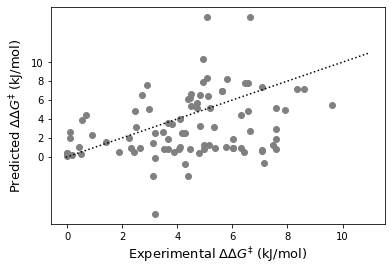

In [393]:
cwf.metrics_for_regression(directories=directory_names)

# Now first we split 90%-10% (train-test)


In [294]:
data = pd.read_csv("Second_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [295]:
test_reactions = [49, 33, 19, 1, 6, 51, 66, 47, 58]

In [296]:
reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64


In [297]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

In [298]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [299]:
substratesmiles_train = train_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_train.head()))

catalystsmiles_train = train_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_train.head()))

ddg_train = train_data["ddg"]
log.info("DGG: {}".format(ddg_train.head()))

Substrate SMILES: 1    O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2
2              O=C1CCC(Cl)N1CCC2=CSC=C2
3      O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3
4              O=C1CCC(Cl)N1CCC2=CNC=C2
5           O=C1CCC(C)(Cl)N1CCC2=CNC=C2
Name: substrate, dtype: object
Catalyst SMILES: 1    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
2    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
3    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
4    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
5    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
Name: catalyst, dtype: object
DGG: 1    0.000000
2    1.426491
3    0.696565
4    3.194526
5    4.777572
Name: ddg, dtype: float64


In [300]:
target_train = ddg_train

In [301]:
substratesmiles_test = test_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_test.head()))

catalystsmiles_test = test_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_test.head()))

ddg_test = test_data["ddg"]
log.info("DGG: {}".format(ddg_test.head()))

Substrate SMILES: 44    O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32
33    O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32
69    O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32
0       O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2
6       O=C1CCC(CCCC)(Cl)N1CCC2=CNC=C2
Name: substrate, dtype: object
Catalyst SMILES: 44    S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=CC=CC=C3)CCCC1...
33    S=C(N[C@H]1[C@H](NS(C(C)(C)C)=O)CCCC1)NC2=CC(C...
69    S=C(N[C@H](C(N(CCCCC)C)=O)C(C)(C)C)N[C@H]1[C@@...
0     CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
6     CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
Name: catalyst, dtype: object
DGG: 44    5.063205
33    0.184448
69    7.590046
0     0.000000
6     4.957045
Name: ddg, dtype: float64


In [302]:
target_test = ddg_test

Mordred for substrates trainset

In [303]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_train = [cwf.get_mol_from_smiles(s) for s in substratesmiles_train]
subfeatures_df_train = calc.pandas(submolecule_list_train)

100%|██████████| 81/81 [00:19<00:00,  4.20it/s]


In [304]:
subfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df_train.index)))
threshold = 0.5
subfeatures_df_train.drop(subfeatures_df_train.std()[subfeatures_df_train.std() < threshold].index.values, axis=1)
subfeatures_df_train.columns = [ent.strip() for ent in subfeatures_df_train.columns]
subfeatures_df_train.head()

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.239595,12.684052,0,0,24.263559,2.353478,4.669240,24.263559,1.277029,3.855916,...,9.676650,65.835337,283.097521,7.651284,765,27,94.0,109.0,6.916667,4.416667
1,10.744501,10.260282,0,0,17.982356,2.336958,4.505232,17.982356,1.284454,3.569498,...,9.224342,60.747309,229.032813,8.808954,322,15,70.0,80.0,4.444444,3.138889
2,14.199155,12.457708,0,0,23.804025,2.410734,4.671853,23.804025,1.322446,3.841465,...,9.752141,67.100439,279.048463,8.720264,630,25,96.0,114.0,5.166667,3.944444
3,10.744501,10.260282,0,0,17.982356,2.336958,4.505232,17.982356,1.284454,3.569498,...,9.224342,60.747309,212.071641,7.854505,322,15,70.0,80.0,4.444444,3.138889
4,11.638886,11.119230,0,0,18.655572,2.421632,4.682800,18.655572,1.243705,3.643595,...,9.536979,62.877757,226.087291,7.536243,377,18,78.0,90.0,5.395833,3.236111


Mordredfor catalysts

In [305]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list_train = [cwf.get_mol_from_smiles(s) for s in catalystsmiles_train]
catfeatures_df_train = calc.pandas(catmolecule_list_train)

100%|██████████| 81/81 [00:32<00:00,  2.53it/s]


In [306]:
catfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(catfeatures_df_train.index)))
threshold = 0.5
catfeatures_df_train.drop(catfeatures_df_train.std()[catfeatures_df_train.std() < threshold].index.values, axis=1)
catfeatures_df_train.columns = [ent.strip() for ent in catfeatures_df_train.columns]
catfeatures_df_train.head()

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
1,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
2,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
3,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778
4,27.439682,23.068997,0,0,44.916702,2.475746,4.882007,44.916702,1.247686,4.489671,...,10.42457,86.33302,510.339233,6.223649,4233,56,182.0,211.0,13.423611,8.027778


Pearsons

In [311]:
subreasonable_predicted_properties, subsignificant_features = cwf.find_correlating_features(subfeatures_df_train, target_train, thresh=0.38, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

1     0.000000
2     1.426491
3     0.696565
4     3.194526
5     4.777572
        ...   
85    4.957045
86    4.088429
87    5.156630
88    6.314769
89    4.464572
Name: ddg, Length: 81, dtype: float64
Significance will be calculated for the correlations
ATS0s: 0.4418 P: 0.0002 Significant at 0.0500 level? True
ATS2s: 0.3973 P: 0.0004 Significant at 0.0500 level? True
ATSC7c: 0.4035 P: 0.0004 Significant at 0.0500 level? True
ATSC8se: -0.3973 P: 0.0004 Significant at 0.0500 level? True
AXp-5d: -0.3946 P: 0.0004 Significant at 0.0500 level? True
AXp-7d: -0.4000 P: 0.0004 Significant at 0.0500 level? True
TIC1: 0.3947 P: 0.0004 Significant at 0.0500 level? True
FilterItLogS: -0.4095 P: 0.0004 Significant at 0.0500 level? True
MPC6: 0.3917 P: 0.0006 Significant at 0.0500 level? True
GGI6: 0.3998 P: 0.0004 Significant at 0.0500 level? True
MWC04: 0.3915 P: 0.0006 Significant at 0.0500 level? True
MWC05: 0.3925 P: 0.0010 Significant at 0.0500 level? True
MWC06: 0.3947 P: 0.0010 Significant

In [312]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_features, len(subsignificant_features)))
use_significant = True
use_reasonable = False

['ATS0s', 'ATS2s', 'ATSC7c', 'ATSC8se', 'AXp-5d', 'AXp-7d', 'TIC1', 'FilterItLogS', 'MPC6', 'GGI6', 'MWC04', 'MWC05', 'MWC06', 'MWC07', 'MWC08', 'MWC09', 'MWC10'] 17
['ATS0s', 'ATS2s', 'ATSC7c', 'ATSC8se', 'AXp-5d', 'AXp-7d', 'TIC1', 'FilterItLogS', 'MPC6', 'GGI6', 'MWC04', 'MWC05', 'MWC06', 'MWC07', 'MWC08', 'MWC09', 'MWC10'] 17


In [314]:
catreasonable_predicted_properties, catsignificant_features = cwf.find_correlating_features(catfeatures_df_train, target_train, thresh=0.49, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

1     0.000000
2     1.426491
3     0.696565
4     3.194526
5     4.777572
        ...   
85    4.957045
86    4.088429
87    5.156630
88    6.314769
89    4.464572
Name: ddg, Length: 81, dtype: float64
Significance will be calculated for the correlations
AATS7se: -0.5005 P: 0.0002 Significant at 0.0500 level? True
AATS7pe: -0.5392 P: 0.0002 Significant at 0.0500 level? True
AATS7are: -0.5280 P: 0.0002 Significant at 0.0500 level? True
AATS3p: -0.5007 P: 0.0002 Significant at 0.0500 level? True
AATS3i: 0.5199 P: 0.0002 Significant at 0.0500 level? True
AATSC0d: -0.5163 P: 0.0002 Significant at 0.0500 level? True
MATS4d: -0.5033 P: 0.0002 Significant at 0.0500 level? True
GATS2c: 0.5076 P: 0.0002 Significant at 0.0500 level? True
GATS4dv: 0.5054 P: 0.0002 Significant at 0.0500 level? True
GATS4d: 0.5570 P: 0.0002 Significant at 0.0500 level? True
Xc-3d: -0.5230 P: 0.0002 Significant at 0.0500 level? True
Xc-4d: -0.5231 P: 0.0002 Significant at 0.0500 level? True
Xc-6d: -0.5049 P: 0.0002

In [315]:
log.info("{} {}".format(catreasonable_predicted_properties, len(catreasonable_predicted_properties)))
log.info("{} {}".format(catsignificant_features, len(catsignificant_features)))
use_significant = True
use_reasonable = False

['AATS7se', 'AATS7pe', 'AATS7are', 'AATS3p', 'AATS3i', 'AATSC0d', 'MATS4d', 'GATS2c', 'GATS4dv', 'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'ETA_shape_x', 'ETA_eta_BR', 'ZMIC3', 'ZMIC4', 'GGI1', 'JGI5'] 19
['AATS7se', 'AATS7pe', 'AATS7are', 'AATS3p', 'AATS3i', 'AATSC0d', 'MATS4d', 'GATS2c', 'GATS4dv', 'GATS4d', 'Xc-3d', 'Xc-4d', 'Xc-6d', 'ETA_shape_x', 'ETA_eta_BR', 'ZMIC3', 'ZMIC4', 'GGI1', 'JGI5'] 19


In [316]:
subfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_features:
        subfeats_df_train[k] = subfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df_train[k] = subfeatures_df_train[k]

In [317]:
catfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in catsignificant_features:
        catfeats_df_train[k] = catfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in catreasonable_predicted_properties:
        catfeats_df_train[k] = catfeatures_df_train[k]

In [338]:
features_df_train = subfeats_df_train.join(catfeats_df_train, lsuffix="subfeats_df_train", rsuffix="catfeats_df_train")

In [339]:
features_df_train.to_csv('features_train.csv')

In [340]:
feature_types = "no_catagorical"
# NOTE: USER DEFINES THE LIST BELOW!!!!!! here is with 0.4 for subs and 0.6 for cats no categorical-spearman
# for 0.36 sub and o.55 cats -spearman
# catagorical_indxs = [23, 25, 48, 49, 50]
# for pearson with 0.36 sub and o.55 cats 
catagorical_indxs = [24]
feature_columns = features_df_train.columns

# Backup
backup_feats_df = features_df_train.copy()

# None catagorical only scale the data as numbers
if feature_types == "no_catagorical":
    mm_scaler = MinMaxScaler()
    features_df_train = mm_scaler.fit_transform(features_df_train)
    log.info(pd.DataFrame(features_df_train, columns=feature_columns))
    features_df_train = pd.DataFrame(features_df_train, columns=feature_columns)
    
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    numeric_features = [feature_columns[i] for i in range(len(feature_columns)) if i not in catagorical_indxs]
    numerical_transformer = MinMaxScaler()
    categorical_features = [feature_columns[i] for i in range(len(feature_columns)) if i in catagorical_indxs]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    if any(ent in categorical_features for ent in numeric_features):
        log.warning("WARNING - numeric and catagorical feature specififed overlap")
        log.info(numeric_features)
        log.info(categorical_features)
    else:
        log.info("Numerical features:\n{} {}".format(numeric_features, len(numeric_features)))
        log.info("Catagorical features:\n{} {}".format(categorical_features, len(catagorical_indxs)))
    
    preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numeric_features),
        ('catagorical', categorical_transformer, categorical_features)])
    
    features_df_train = preprocessor.fit_transform(features_df_train)
    feature_names = cwf.get_feature_names_from_column_transformers(preprocessor)
    catagorical_indxs = [i for i in range(len(numeric_features), len(feature_names))]
    log.info(feature_names)

    log.info(pd.DataFrame(features_df_train, columns=feature_names))
    features_df_train = pd.DataFrame(features_df_train, columns=feature_names)
    log.info("catagorical indexes {}".format(catagorical_indxs))
    log.info("Catagorical features start on column name {} and end on {}".format(features_df_train.columns[catagorical_indxs[0]], features_df_train.columns[catagorical_indxs[-1]]))
    
# All catagorical
elif feature_types == "catagorical":
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    features_df_train = categorical_transformer.fit_transform(features_df_train).toarray()
    feature_names = [categorical_transformer.get_feature_names(feature_columns)]
    features_df_train = pd.DataFrame(features_df_train, columns=feature_names)
    log.info(features_df_train)

# No scaling or other encoding
else:
    log.info("No scaling")

       ATS0s     ATS2s    ATSC7c   ATSC8se    AXp-5d    AXp-7d      TIC1  \
0   0.518462  0.476068  0.000000  1.000000  0.825526  0.818836  0.276107   
1   0.000000  0.000000  0.104473  0.457670  1.000000  1.000000  0.000000   
2   0.184826  0.227432  0.016908  0.398103  0.548194  0.391876  0.217109   
3   0.081151  0.101813  0.538108  0.310377  1.000000  1.000000  0.053729   
4   0.149883  0.179366  0.610300  0.266860  0.791364  0.736606  0.134711   
..       ...       ...       ...       ...       ...       ...       ...   
76  0.537027  0.588353  1.000000  0.302564  0.278724  0.172396  0.521504   
77  0.316474  0.400554  0.469883  0.261812  0.461579  0.424379  0.344175   
78  0.385206  0.478106  0.575754  0.200286  0.326537  0.279967  0.430913   
79  0.536697  0.667434  0.635650  0.215952  0.398144  0.352357  0.602735   
80  0.352531  0.425172  0.626794  0.220592  0.477745  0.259003  0.323340   

    FilterItLogS      MPC6      GGI6  ...    GATS4d     Xc-3d  Xc-4d  \
0       0.72241

Test set

In [321]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_test = [cwf.get_mol_from_smiles(s) for s in substratesmiles_test]
subfeatures_df_test = calc.pandas(submolecule_list_test)

100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


In [322]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list_test = [cwf.get_mol_from_smiles(s) for s in catalystsmiles_test]
catfeatures_df_test = calc.pandas(catmolecule_list_test)

100%|██████████| 9/9 [00:03<00:00,  2.45it/s]


In [323]:
testfeats_df_sub = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure feature cover all of the molecule if not don't use them as we will loose data points doing this
n_features = len(ddg_train)

# Add Mordred descriptors
for ent in subreasonable_predicted_properties:
#     tmp = testfeatures_df[ent].copy()
#     tmp.dropna(inplace=True)
#     if len(tmp.values) == n_features:
    testfeats_df_sub[ent] = subfeatures_df_test[ent].values 
#     print(testfeats_df[ent])
    testcontinous_features.append(ent)
#     else:
#         log.warning("Dropping feature because it is not avaliable for all molecules")
#     del tmp
print(testfeats_df_sub)

        ATS0s       ATS2s    ATSC7c   ATSC8se    AXp-5d    AXp-7d        TIC1  \
0  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
1  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
2  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
3  122.171963  158.944444  0.161211 -0.094886  0.086401  0.039421  105.445456   
4  120.928908  166.936728  0.183510 -0.746677  0.083112  0.035947  119.888931   
5  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
6  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
7  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
8  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   

   FilterItLogS  MPC6      GGI6     MWC04     MWC05     MWC06     MWC07  \
0     -4.058288    48  0.305306  6.308098  7.178545  8.056110  8.929700   
1     -4.058288    48  0.305306  6.3080

In [324]:
testfeats_df_cat = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure feature cover all of the molecule if not don't use them as we will loose data points doing this
n_features = len(ddg_train)

# Add Mordred descriptors
for ent in catreasonable_predicted_properties:
#     tmp = testfeatures_df[ent].copy()
#     tmp.dropna(inplace=True)
#     if len(tmp.values) == n_features:
    testfeats_df_cat[ent] = catfeatures_df_test[ent].values 
#     print(testfeats_df[ent])
    testcontinous_features.append(ent)
#     else:
#         log.warning("Dropping feature because it is not avaliable for all molecules")
#     del tmp
print(testfeats_df_cat)

    AATS7se   AATS7pe  AATS7are    AATS3p      AATS3i   AATSC0d    MATS4d  \
0  7.204294  5.601706  5.521705  1.325207  159.173817  0.579074 -0.052471   
1  7.754089  6.233196  6.158869  1.386360  160.607467  0.813457  0.096605   
2  7.224031  5.656771  5.566645  1.366152  157.943186  0.590393 -0.021433   
3  7.209765  5.616365  5.533711  1.311819  159.387599  0.566924 -0.041737   
4  7.209765  5.616365  5.533711  1.311819  159.387599  0.566924 -0.041737   
5  7.218353  5.640011  5.553213  1.314738  159.345370  0.587023 -0.050939   
6  7.255502  5.701951  5.610367  1.437375  155.741870  0.599506 -0.072928   
7  7.232044  5.659775  5.572159  1.361851  157.919823  0.590393 -0.028915   
8  7.322376  5.759959  5.680135  1.283586  158.101807  0.657055 -0.025106   

     GATS2c   GATS4dv    GATS4d     Xc-3d     Xc-4d     Xc-6d  ETA_shape_x  \
0  1.252801  1.290852  1.211650  3.153016  0.288675  0.117851     0.028958   
1  0.639182  0.871263  0.741670  5.417008  0.866025  0.492799     0.10406

In [325]:
features_df_test = testfeats_df_sub.join(testfeats_df_cat, lsuffix="subfeats_df", rsuffix="catfeats_df")

In [326]:
features_df_test

,ATS0s,ATS2s,ATSC7c,ATSC8se,AXp-5d,AXp-7d,TIC1,FilterItLogS,MPC6,GGI6,...,GATS4d,Xc-3d,Xc-4d,Xc-6d,ETA_shape_x,ETA_eta_BR,ZMIC3,ZMIC4,GGI1,JGI5
0,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.211650,3.153016,0.288675,0.117851,0.028958,1.042966,29.107191,27.820689,7.5,0.019936
1,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,0.741670,5.417008,0.866025,0.492799,0.104063,1.516678,47.448600,45.415826,12.0,0.039028
2,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.165670,3.425182,0.288675,0.117851,0.025295,1.145803,30.925159,28.413124,8.0,0.019335
3,122.171963,158.944444,0.161211,-0.094886,0.086401,0.039421,105.445456,-3.453405,32,0.232744,...,1.202450,3.153016,0.288675,0.117851,0.028143,1.042966,29.604637,27.803492,7.5,0.020476
4,120.928908,166.936728,0.183510,-0.746677,0.083112,0.035947,119.888931,-4.504442,36,0.341270,...,1.202450,3.153016,0.288675,0.117851,0.028143,1.042966,29.604637,27.803492,7.5,0.020476
5,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.186566,3.276431,0.288675,0.117851,0.027372,1.094491,35.598633,30.667332,7.5,0.021397
6,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.268413,3.554209,0.288675,0.117851,0.022971,1.197328,36.849320,33.026551,8.0,0.019429
7,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.133126,3.486350,0.288675,0.117851,0.025295,1.162640,31.280681,29.122579,8.5,0.020359
8,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.129234,6.781693,0.930904,0.214076,0.073409,1.973297,42.399559,41.561828,14.5,0.027948


In [327]:
feature_types = "no_catagorical"
# NOTE: USER DEFINES THE LIST BELOW!!!!!! here is with 0.4 for subs and 0.6 for cats no categorical-spearman
# for 0.36 sub and o.55 cats -spearman
# catagorical_indxs = [23, 25, 48, 49, 50]
# for pearson with 0.36 sub and o.55 cats 
catagorical_indxs = [24]
feature_columns = features_df_test.columns

# Backup
backup_feats_df = features_df_test.copy()

# None catagorical only scale the data as numbers
if feature_types == "no_catagorical":
    mm_scaler = MinMaxScaler()
    features_df_train = mm_scaler.fit_transform(features_df_test)
    log.info(pd.DataFrame(features_df_test, columns=feature_columns))
    features_df_test = pd.DataFrame(features_df_test, columns=feature_columns)
    
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    numeric_features = [feature_columns[i] for i in range(len(feature_columns)) if i not in catagorical_indxs]
    numerical_transformer = MinMaxScaler()
    categorical_features = [feature_columns[i] for i in range(len(feature_columns)) if i in catagorical_indxs]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    if any(ent in categorical_features for ent in numeric_features):
        log.warning("WARNING - numeric and catagorical feature specififed overlap")
        log.info(numeric_features)
        log.info(categorical_features)
    else:
        log.info("Numerical features:\n{} {}".format(numeric_features, len(numeric_features)))
        log.info("Catagorical features:\n{} {}".format(categorical_features, len(catagorical_indxs)))
    
    preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numeric_features),
        ('catagorical', categorical_transformer, categorical_features)])
    
    features_df_test = preprocessor.fit_transform(features_df_test)
    feature_names = cwf.get_feature_names_from_column_transformers(preprocessor)
    catagorical_indxs = [i for i in range(len(numeric_features), len(feature_names))]
    log.info(feature_names)

    log.info(pd.DataFrame(features_df_test, columns=feature_names))
    features_df_test = pd.DataFrame(features_df_test, columns=feature_names)
    log.info("catagorical indexes {}".format(catagorical_indxs))
    log.info("Catagorical features start on column name {} and end on {}".format(features_df_test.columns[catagorical_indxs[0]], features_df_test.columns[catagorical_indxs[-1]]))
    
# All catagorical
elif feature_types == "catagorical":
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    features_df_test = categorical_transformer.fit_transform(features_df_test).toarray()
    feature_names = [categorical_transformer.get_feature_names(feature_columns)]
    features_df_test = pd.DataFrame(features_df_test, columns=feature_names)
    log.info(features_df_test)

# No scaling or other encoding
else:
    log.info("No scaling")

        ATS0s       ATS2s    ATSC7c   ATSC8se    AXp-5d    AXp-7d        TIC1  \
0  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
1  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
2  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
3  122.171963  158.944444  0.161211 -0.094886  0.086401  0.039421  105.445456   
4  120.928908  166.936728  0.183510 -0.746677  0.083112  0.035947  119.888931   
5  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
6  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
7  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   
8  117.949741  162.222222  0.115396 -0.672010  0.080059  0.033416  116.326040   

   FilterItLogS  MPC6      GGI6  ...    GATS4d     Xc-3d     Xc-4d     Xc-6d  \
0     -4.058288    48  0.305306  ...  1.211650  3.153016  0.288675  0.117851   
1     -4.058288    48  0.3053

here if the categorical feature has less options in the test than the train you end up with 
less features in total for the test. so i guess we need to see which ones are missing and add the columns with 0s

In [328]:
if len(features_df_train) != len(features_df_test):

    diff = features_df_train.columns.difference(features_df_test.columns)
    for i in range(len(diff)):
        print(diff[i])
        features_df_test[diff[i]] = [0,0,0,0,0,0,0,0,0]

In [329]:
features_df_test

,ATS0s,ATS2s,ATSC7c,ATSC8se,AXp-5d,AXp-7d,TIC1,FilterItLogS,MPC6,GGI6,...,GATS4d,Xc-3d,Xc-4d,Xc-6d,ETA_shape_x,ETA_eta_BR,ZMIC3,ZMIC4,GGI1,JGI5
0,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.211650,3.153016,0.288675,0.117851,0.028958,1.042966,29.107191,27.820689,7.5,0.019936
1,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,0.741670,5.417008,0.866025,0.492799,0.104063,1.516678,47.448600,45.415826,12.0,0.039028
2,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.165670,3.425182,0.288675,0.117851,0.025295,1.145803,30.925159,28.413124,8.0,0.019335
3,122.171963,158.944444,0.161211,-0.094886,0.086401,0.039421,105.445456,-3.453405,32,0.232744,...,1.202450,3.153016,0.288675,0.117851,0.028143,1.042966,29.604637,27.803492,7.5,0.020476
4,120.928908,166.936728,0.183510,-0.746677,0.083112,0.035947,119.888931,-4.504442,36,0.341270,...,1.202450,3.153016,0.288675,0.117851,0.028143,1.042966,29.604637,27.803492,7.5,0.020476
5,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.186566,3.276431,0.288675,0.117851,0.027372,1.094491,35.598633,30.667332,7.5,0.021397
6,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.268413,3.554209,0.288675,0.117851,0.022971,1.197328,36.849320,33.026551,8.0,0.019429
7,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.133126,3.486350,0.288675,0.117851,0.025295,1.162640,31.280681,29.122579,8.5,0.020359
8,117.949741,162.222222,0.115396,-0.672010,0.080059,0.033416,116.326040,-4.058288,48,0.305306,...,1.129234,6.781693,0.930904,0.214076,0.073409,1.973297,42.399559,41.561828,14.5,0.027948


# Define Xtrain, Xtest, Ytrain, Ytest

In [348]:
Xtrain = features_df_train
Xtest = features_df_test
Ytrain = target_train
Ytest = target_test

In [349]:
print(target_train)

1     0.000000
2     1.426491
3     0.696565
4     3.194526
5     4.777572
        ...   
85    4.957045
86    4.088429
87    5.156630
88    6.314769
89    4.464572
Name: ddg, Length: 81, dtype: float64


# Time to ML

In [350]:
def grid_search_reg_parameters(rgs, Xtrain, ytrain, rgs_options, rgs_names, iteration, no_train_output, cv=5, name=None,scoring=("r2","neg_root_mean_squared_error")):
    """
    Grid search regressor hyperparams and find the best report metrics if requested
    """
    
    # Grid search model optimizer

    parameters = rgs_options
    log.info("\tname: {} parameters: {}".format(name, parameters))
    
    optparam_search = GridSearchCV(rgs, parameters, cv=cv, error_score=np.nan, scoring=scoring, refit=scoring[0], return_train_score=True)
#     print("\tCV xtrain: {}".format(Xtrain))
    
    optparam_search.fit(Xtrain, ytrain)
    opt_parameters = optparam_search.best_params_
    
    if no_train_output is False:
        reported_metrics = pd.DataFrame(data=optparam_search.cv_results_)
        reported_metrics.to_csv("{}/{}_grid_search_metrics.csv".format(name,name))
        log.info("\tBest parameters; {}".format(opt_parameters))

        for mean, std, params in zip(optparam_search.cv_results_["mean_test_{}".format(scoring[0])], optparam_search.cv_results_["std_test_{}".format(scoring[0])], optparam_search.cv_results_['params']):
            log.info("\t{:.4f} (+/-{:.4f}) for {}".format(mean, std, params))
    else:
        pass
    
    return opt_parameters

In [351]:
def minmaxscale(df):
    """
    scale a pandas dataframe using min max scaling
    :param df: pandas dataframe - data frame to be returned scaled
    """
    
    df_tmp = df.copy()
    normalized_df = (df_tmp-df_tmp.min())/(df_tmp.max()-df_tmp.min())
    return normalized_df

In [352]:
# Possible source:    https://www.kaggle.com/ankitjha/comparing-regression-models
# kfold_reg_names = ["DecisionTreeRegressor", "SVR", "BayesianRegr", "GaussianProcessRegressor"]


kfold_reg_names = ["LassoCV","KNeighborsRegressor", "DecisionTreeRegressor", "SVR", 
                   "BayesianRegr", "GaussianProcessRegressor"]
kfold_regressors = [
    LassoCV(random_state=random_seed, cv=10,selection='random',normalize=True,max_iter=1000000),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=random_seed),
    svm.SVR(),
    linear_model.BayesianRidge(n_iter=100000,normalize=True),
    GaussianProcessRegressor()]

kernel = DotProduct() + WhiteKernel()
kfold_regressors_parameters = {
    "LassoCV":{},
    "KNeighborsRegressor": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "DecisionTreeRegressor": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "SVR": {"kernel":['linear', 'poly', 'rbf'], "degree":[2,3], "gamma":['auto','scale'], "coef0":[0,1], 'C':[100]},    
    "BayesianRegr":{'alpha_1':[1e-06, 10], 'alpha_2': [1e-06,10],'lambda_1':[1e-06,10], 'lambda_2': [1e-06,10]},
    "GaussianProcessRegressor": {},  

    
}

In [353]:
from joblib import dump, load
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
def test_regressors_with_optimization(df, targets, test_df, test_targets, regressors, rgs_options, scale=True, cv=5, 
                                      n_repeats=20, rgs_names=None, 
                                    no_train_output=False, random_seed=107901, overwrite=True):
    """
    function to run regression 
    """
    all_test_metrics = []
    iteration = 0
        
    if rgs_names is None:
        rgs_names = [i for i in range(0, len(regressors))]

    log.info("Starting regression")
    for name, reg in zip(rgs_names, regressors):
        log.info("\n-----\nBegin {}\n-----\n".format(name))
        name = "{}".format("_".join(name.split()))
        
        # Make directory for each regressor
        if not os.path.isdir(name):
            os.makedirs(name, exist_ok = True)
        elif overwrite is False and os.path.isdir(name) is True:
            log.warning("Directory already exists and overwrite is False will stop before overwriting.".format(name))
            return None
        else:
            log.info("Directory {} already exists will be overwritten".format(name))
            
#         Train set
        Xtrain = df
#         log.info("Train X\n{}".format(Xtrain))
        ytrain = targets
#         log.info("Train Y\n{}".format(ytrain))
        
#         Find optimal parameters
        opt_param = grid_search_reg_parameters(reg, Xtrain, ytrain, rgs_options[name], rgs_names, iteration, no_train_output, cv=cv, name=name)
            
        # Fit model using optimized parameters 
        reg.set_params(**opt_param)
        reg.fit(Xtrain, ytrain)
        
#         Save Model        
        targ = 'ddg'
        dump(reg, "{}/model_{}_{}_fixed.joblib".format(name,name, targ))
        
#         Test set    
        Xtest = test_df
#         log.info("Test X\n{}".format(Xtest))
        ytest = test_targets
#         log.info("Test Y\n{}".format(ytest))
        
#         Evaluate the model based on the validation set
        test_predictions = reg.predict(Xtest)
        log.info("\n\t The predictions are: {}".format(test_predictions))
        
#         Calculate metrics for regression
        test_metrics = {}
        test_metrics['name'] = name
        test_metrics["variance"] = round(explained_variance_score(test_targets, test_predictions),2)
        test_metrics["MAE"] = round(mean_absolute_error(test_targets, test_predictions),2)
        test_metrics["MSE"] = round(mean_squared_error(test_targets, test_predictions),2)
        test_metrics["RMSE"] = math.sqrt(round(mean_squared_error(test_targets, test_predictions),2))
        test_metrics["R2"] = round(r2_score(test_targets, test_predictions),2)
    
        log.info(test_metrics)
        all_test_metrics.append(test_metrics)
    
    
        plt.figure(figsize=(6,4))
        plt.scatter(test_targets,test_predictions, color='blue',marker='x')
        plt.ylabel('Predicted Δ∆$G^{‡}$ (kJ/mol)', fontsize=13)
        plt.xlabel('Experimental Δ∆$G^{‡}$ (kJ/mol)', fontsize=13)
        plt.plot([-0.05, 11], [-0.05, 11], "k:")

        plt.xticks(np.arange(0, 12, step=2))
        plt.yticks(np.arange(0, 12, step=2))
        plt.savefig('{}/{}.png'.format(name,name))
    
    all_test_metrics = pd.DataFrame(all_test_metrics)
    all_test_metrics.to_csv('test_metrics.csv')

In [354]:
%%capture
test_regressors_with_optimization(Xtrain,Ytrain,Xtest,Ytest, kfold_regressors, kfold_regressors_parameters, scale=True, cv=5, n_repeats=10, rgs_names=kfold_reg_names)

Starting regression

-----
Begin LassoCV
-----

Directory LassoCV already exists will be overwritten
	name: LassoCV parameters: {}
	Best parameters; {}
	-0.1903 (+/-0.6013) for {}

	 The predictions are: [68.39461981 38.0631078  65.35725666 69.54404318 70.59844601 58.02083231
 56.01182031 64.76361346 47.01570503]
{'name': 'LassoCV', 'variance': -16.43, 'MAE': 55.87, 'MSE': 3215.29, 'RMSE': 56.703527227148754, 'R2': -595.14}

-----
Begin KNeighborsRegressor
-----

	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
	Best parameters; {'n_neighbors': 9}
	-1.0002 (+/-1.2797) for {'n_neighbors': 2}
	-1.1613 (+/-1.1475) for {'n_neighbors': 3}
	-0.8962 (+/-0.9829) for {'n_neighbors': 4}
	-0.8063 (+/-0.9348) for {'n_neighbors': 5}
	-0.6494 (+/-0.9343) for {'n_neighbors': 6}
	-0.6085 (+/-0.9406) for {'n_neighbors': 7}
	-0.5474 (+/-0.9325) for {'n_neighbors': 8}
	-0.5333 (+/-0.9535) for {'n_neighbors': 9}

	 The predictions are: [5.94584849 5.94584849 5.94584849 5.94